In [1]:
import os
import re
import sys
import string
import itertools
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

from app.backend.utils import DbEngine, Queries
from app.backend.etl import ETL
from app.backend.etl_sdhi import ETL_SDHI
from app.encoding_module.encoder import Encoding

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import calinski_harabasz_score, fowlkes_mallows_score, silhouette_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, TimeSeriesSplit, StratifiedKFold, cross_validate

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import lightgbm as lgb

from kmodes.kmodes import KModes
from scipy.spatial import distance
from scipy import stats
from scipy.stats import uniform, randint

import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
plt.style.use('seaborn')

In [3]:
pd.set_option("display.max_columns", 100)

### Connect to DB

In [4]:
db_engine = DbEngine(user = 'team77', 
                     password = 'mintic2020.',
                     ip = '172.17.0.3', 
                     port = '5432', 
                     db = 'minjusticia')
engine = db_engine.connect()
queries = Queries(engine)

### Loading original data

In [5]:
data = pd.read_excel('data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)
data_shdi = pd.read_excel('data/SHDI Colombia 4.0.xlsx')

In [6]:
data2 = data[['INTERNOEN', 'DELITO', 'TITULO_DELITO', 'SUBTITULO_DELITO', 'TENTATIVA',
       'AGRAVADO', 'CALIFICADO', 'FECHA_INGRESO', 'FECHA_SALIDA',
       'FECHA_CAPTURA', 'SITUACION_JURIDICA', 'ANO_NACIMIENTO', 'EDAD',
       'GENERO', 'ESTADO_CIVIL', 'PAIS_INTERNO', 'DEPARTAMENTO', 'CIUDAD',
       'REINCIDENTE', 'ESTADO_INGRESO', 'ACTIVIDADES_TRABAJO',
       'ACTIVIDADES_ESTUDIO', 'ACTIVIDADES_ENSEÑANZA', 'NIVEL_EDUCATIVO',
       'HIJOS_MENORES', 'CONDIC_EXPECIONAL', 'CODIGO_ESTABLECIMIENTO',
       'ESTABLECIMIENTO', 'DEPTO_ESTABLECIMIENTO', 'MPIO_ESTABLECIMIENTO',
       'REGIONAL', 'ESTADO']]

### Execute ETL

In [7]:
etl = ETL(queries)
etl.inmate_static_info(data2)
etl.inmate_variable_info(data2)

/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/backend/etl.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['CONDIC_EXPECIONAL'] = data_reg['CONDIC_EXPECIONAL'].fillna('NINGUNO')
/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/backend/etl.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['madre_gestante'] = 'NA'
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,crime,min_month,max_month,decree
0,HURTO,16,108,239
1,TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,128,360,376
2,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,132,180,366
3,CONCIERTO PARA DELINQUIR,48,108,340
4,HOMICIDIO,208,450,103
5,EXTORSION,192,288,244
6,"FABRICACIÓN, TRÁFICO, PORTE O TENENCIA DE ARMA...",108,144,365
7,VIOLENCIA INTRAFAMILIAR,48,720,229
8,LESIONES PERSONALES,16,360,"[111, 112, 113, 114, 115, 116, 117, 118, 119, ..."
9,FABRICACION TRAFICO Y PORTE DE ARMAS Y MUNICI...,132,180,366


,INTERNOEN,GENERO,DELITO,ESTADO_INGRESO,FECHA_CAPTURA,FECHA_INGRESO,ESTABLECIMIENTO,TENTATIVA,SUBTITULO_DELITO,AGRAVADO,CALIFICADO,FECHA_SALIDA,EDAD,DEPARTAMENTO,CIUDAD,ACTIVIDADES_TRABAJO,ACTIVIDADES_ESTUDIO,ACTIVIDADES_ENSEÑANZA,HIJOS_MENORES,CONDIC_EXPECIONAL,ESTADO,SITUACION_JURIDICA,madre_gestante,madre_lactante,discapacidad,adulto_mayor,crime_score
0,5496C737C624136DB406CFC6744C684C070A3CD8,MASCULINO,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,Intramuros,30/12/09,01/01/10,EPMSC MEDELLIN,N,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,12/05/11,48,ANTIOQUIA,ENVIGADO-ANTIOQUIA,SI,SI,NO,SI,NINGUNO,Baja,CO,NA,NA,N,N,4


,TENTATIVA,AGRAVADO,CALIFICADO,multiplier
0,N,N,N,2
1,N,S,S,8
2,N,N,S,7
3,N,S,N,6
4,S,S,N,3
5,S,N,N,1
6,S,S,S,5
7,S,N,S,4


/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/backend/etl.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['CONSUMADO_b']  = data_reg.TENTATIVA.apply(lambda x: 4 if x=="N" else 0)
/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/backend/etl.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['TENTATIVA_b'] = data_reg.TENTATIVA.apply(lambda x: 3 if x=="S" else 0)
/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/backend/etl.py:130: SettingWithCopyWarning: 
A value is

In [8]:
etl_sdhi = ETL_SDHI(queries)
etl_sdhi.inmate_static_info(data_shdi)

### Functions

#### encodings

In [5]:
def encode_transform(data):
    encoders = []
    encoded_cols = []
    for i in range(data.values.shape[1]):
        le = LabelEncoder()
        le.fit(data.values[:,i])
        encoders.append(le)
        encoded_cols.append(le.transform(data.values[:,i]).reshape(-1,1))
    return np.concatenate(encoded_cols, axis = 1), encoders

#### metrics-results

In [6]:
def plot_confusion_matrix(labels, prediction, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.get_cmap('Blues')):
    """ Dibuja la matriz de confusion de los resultados de clasificacion de un modelo.
    Se puede aplicar normalizacion ajustando 'normalize=True'. """

    n = len(classes)
    if len(prediction.shape) != 1:
        matrix = multilabel_confusion_matrix(labels, prediction).reshape(n,4)
    else:
        matrix = confusion_matrix(labels, prediction)

    size = 1.4 * len(classes)
    plt.figure(figsize=(size, size))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))

    if len(prediction.shape) != 1:
        plt.xticks(tick_marks, ['True Negatives', 'False Negatives', 'False Positives', 'True Positives'], rotation=90)
    else:
        plt.xticks(tick_marks, classes, rotation=90)

    plt.yticks(tick_marks, classes)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment='center',
                 color='white' if matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def classifier_results(prediction, labels, classes, show_plots):
    """ Muestra los resultados de accuracy, presenta los resultados de precision, recall y f1-score
    y genera la matriz de confusion para el conjunto de datos."""

    print('\nAccuracy:\n{0:.2f}'.format(accuracy_score(labels, prediction)))

    print(classification_report(labels, prediction, digits=2, target_names = classes))
    
    if show_plots:
        plot_confusion_matrix(labels, prediction, classes)

    return classification_report(labels, prediction, digits=2, output_dict=True)

def plot_roc(y_test, y_preds):
    """
    Helper function that plots the roc curve
    """
    plt.figure(figsize=(8,8))
    for label in np.unique(y_test):
        fpr, tpr, _ = roc_curve(y_test == label, y_preds == label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
        #plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic ROC')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall(y_test, y_preds):
    #plt.figure(figsize=(8,8))
    #for idx, label in enumerate(classes):
    #    roc_auc = auc(x[idx], y[idx])
    #    plt.plot(x[idx], y[idx], linewidth=2, label=str(label) + ': ' + 'AUC = ' + '{0:.2f}'.format(roc_auc) + ' - ' +
    #                                                               'AP = ' + '{0:.2f}'.format(ap[idx]) + ' - ' +
    #                                                               'F1 = ' + '{0:.2f}'.format(f1[idx]))
    #plt.xlim([0.0, 1.05])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('Recall')
    #plt.ylabel('Precision')
    #plt.title('Precision Recall Curve')
    #plt.legend(loc="lower right")
    #plt.grid()
    #plt.show()
    """
    Helper function that plots the roc precision recall Curve
    """
    plt.figure(figsize=(8,8))
    for label in np.unique(y_test):
        fpr, tpr, _ = precision_recall_curve(y_test == label, y_preds == label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
        #plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

In [170]:
def radar_plot(df):
    categories = df['feature_name'].tolist()

    fig = go.Figure()
    for label in df.label.unique():
        fig.add_trace(go.Scatterpolar(
              #r=np.log(df[df['label'] == label]['feature_importance'] + 0.00001),
              r = df[df['label'] == label]['feature_importance'],
              theta=categories,
              #fill='toself',
              name='Cluster {}'.format(label)
        ))

    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          #range=[data_plot['feature_importance'].min(), data_plot['feature_importance'].max()]
        )),
      showlegend=False
    )

    fig.show()

#### algorithms

In [8]:
##### Get closest centroid unoptimized (Prediction Strength)
def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

##### Get closest centroid optimized v1 (Prediction Strength)
def get_closest_centroid_optim(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance)
    
    return centroids[idx_min_distance]

##### Get closest centroid optimized v2 (Prediction Strength)
def get_closest_centroid_optim_vectorized(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance, axis = 0)
    
    return centroids[idx_min_distance]

##### Get prediction strength unoptimized (Prediction Strength)
def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

##### Get prediction strength optimized (Prediction Strength)
def get_prediction_strength_optim(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    closest_cent = get_closest_centroid_optim_vectorized(x_test, train_centroids)
    
    co_membership = np.zeros((len(closest_cent), len(closest_cent)))
    for i in range(1, len(closest_cent)):
        diag = (closest_cent == np.roll(closest_cent, shift = i, axis = 0)).all(1)[i:]
        co_membership[range(i,len(closest_cent)),range(len(diag))] = diag
    co_membership = co_membership + co_membership.T - np.diag(np.diag(co_membership))
    
    # calculate the prediction strengths for each cluster
    n_test = len(x_test)
    ss = []
    for j in range(k):
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        test_labels_co_mem = np.zeros((len(test_labels), len(test_labels)))
        for i in range(len(test_labels)):
            diag = (test_labels == np.roll(test_labels, shift = i)) & (test_labels == j)
            diag = diag[i:]
            test_labels_co_mem[range(i,len(test_labels)),range(len(diag))] = diag
        test_labels_co_mem = test_labels_co_mem + test_labels_co_mem.T - np.diag(np.diag(test_labels_co_mem))
        s = (co_membership * test_labels_co_mem).sum()
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

### Encode

In [9]:
encoding = Encoding(queries)

In [10]:
inmate_sup = encoding.get_data('encoding')

In [11]:
data_encoded = encoding.one_hot(inmate_sup)

In [12]:
data_encoded.shape

(103290, 46)

#### Evaluating remaining Nans

Im gonna delete the out dates

In [13]:
data_encoded.isnull().sum().to_frame().rename(columns={0:'counts'}).sort_values(by='counts', ascending = False)

,counts
fecha_salida,30304
mean_severity,27934
max_severity,27934
pop,16513
msch,16513
esch,16513
gnic,16513
lifexp,16513
edindex,16513
healthindex,16513


In [14]:
data_encoded = data_encoded[data_encoded.columns[~data_encoded.columns \
                                                 .isin(['fecha_salida','mean_severity','max_severity',
                                                        'pop','msch','esch','gnic','lifexp','edindex',
                                                        'shdi','incindex','healthindex'])]]
data_encoded.shape

(103290, 34)

#### Deleting not important features for the analysis

In [15]:
identity = data_encoded[['internoen','fecha_ingreso']]

In [16]:
data_encoded = data_encoded[data_encoded.columns[~data_encoded.columns \
                                                 .isin(['internoen',
                                                        'fecha_ingreso',
                                                        'fecha_captura'])]]
data_encoded.shape

(103290, 32)

#### Fixing non-ASCII characters in colums names.

In [17]:
data_encoded = data_encoded.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#### Label Encoder

In [18]:
data_encoded_mat, encoders = encode_transform(data_encoded)
data_encoded_mat.shape

(103290, 32)

### Supervised Model to check feature importances

#### Labels from training GMM with optimal number

In [23]:
cluster_labels = pd.read_csv('./data/cluster_labels.csv')
cluster_labels['LABEL'].value_counts().to_frame()

,LABEL
4,36692
3,34391
1,15722
2,10112
0,6299


#### Data Spliting

In [107]:
unique_indices = identity[['internoen','fecha_ingreso']].rename(columns = {'internoen':'INTERNOEN',
                                                                           'fecha_ingreso': 'FECHA_INGRESO'})
#unique_indices = unique_indices.sort_values(by='INTERNOEN')
unique_indices['FECHA_INGRESO'] = unique_indices['FECHA_INGRESO'].astype(str)
unique_indices = unique_indices[unique_indices[['INTERNOEN', 'FECHA_INGRESO']].apply(tuple, axis=1) \
                       .isin(cluster_labels[['INTERNOEN','FECHA_INGRESO']].apply(tuple, axis=1).tolist())]
#unique_indices = unique_indices.reset_index(drop = True)
unique_inmate = unique_indices['INTERNOEN'].unique()

In [118]:
inmate_train, inmate_test = train_test_split(unique_inmate, 
                                             test_size=0.2, 
                                             shuffle=True, 
                                             random_state=42)

In [126]:
index_train_X = unique_indices[unique_indices['INTERNOEN'].isin(inmate_train)].index.values
index_test_X = unique_indices[unique_indices['INTERNOEN'].isin(inmate_test)].index.values
index_train_Y = cluster_labels[cluster_labels['INTERNOEN'].isin(inmate_train)].index.values
index_test_Y = cluster_labels[cluster_labels['INTERNOEN'].isin(inmate_test)].index.values

In [127]:
# train/test split
X_train = data_encoded_mat[index_train_X]
X_test = data_encoded_mat[index_test_X]
Y_train = cluster_labels['LABEL'][index_train_Y].values
Y_test = cluster_labels['LABEL'][index_test_Y].values

In [131]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((82555, 32), (20661, 32), (82555,), (20661,))

#### LightGBM Classifier

##### Hyperparameter Search

In [153]:
model = lgb.LGBMClassifier(objective = "multiclassova",
                           num_class = 5,
                           metric = ["multi_error", "multi_logloss"],
                           is_unbalance = True,
                           #scale_pos_weight = sum(Y_train == 0)/sum(Y_train == 1),
                           importance_type = 'gain'
                          )

In [154]:
distributions_lgb = dict(
                     #lambda_l1=uniform(loc=0, scale=50),
                     lambda_l2=uniform(loc=0, scale=1),
                     min_gain_to_split=uniform(loc=0, scale=50),
                     max_depth = randint(1, 2000),
                     n_estimators = randint(1, 2000),
                     num_iterations = randint(1, 200),
                     num_leaves = randint(1, 20000),
                     learning_rate = uniform(loc=0, scale=0.2),
                     bagging_fraction = uniform(loc=0.2, scale=0.8),
                     bagging_freq = randint(0, 5),
                     feature_fraction = uniform(loc=0.2, scale=0.8),
                     #min_data_in_leaf = randint(1, 30000)
                    )
clf_lgb = RandomizedSearchCV(
                         model, 
                         distributions_lgb, 
                         random_state=42, 
                         cv = StratifiedKFold(n_splits=10),
                         scoring = 'f1_weighted'
                         #scoring = ['precision','recall','roc_auc'],
                         #refit = 'precision'
                        )
search_lgb = clf_lgb.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

In [155]:
search_lgb.best_params_

{'bagging_fraction': 0.4433937943676302,
 'bagging_freq': 4,
 'feature_fraction': 0.5455560149136927,
 'lambda_l2': 0.2912291401980419,
 'learning_rate': 0.1223705789444759,
 'max_depth': 1706,
 'min_gain_to_split': 2.3332831606807716,
 'n_estimators': 700,
 'num_iterations': 15,
 'num_leaves': 190}

##### Model Training with tuned hyperparameters

In [156]:
hyper_params = search_lgb.best_params_.copy()
hyper_params

{'bagging_fraction': 0.4433937943676302,
 'bagging_freq': 4,
 'feature_fraction': 0.5455560149136927,
 'lambda_l2': 0.2912291401980419,
 'learning_rate': 0.1223705789444759,
 'max_depth': 1706,
 'min_gain_to_split': 2.3332831606807716,
 'n_estimators': 700,
 'num_iterations': 15,
 'num_leaves': 190}

In [157]:
metrics_to_eval = ["multi_error", "multi_logloss"]

In [158]:
model = lgb.LGBMClassifier(objective = "multiclassova",
                                   num_class = 5,
                                   metric = metrics_to_eval,
                                   learning_rate = hyper_params['learning_rate'],
                                   feature_fraction = hyper_params['feature_fraction'],
                                   bagging_fraction = hyper_params['bagging_fraction'],
                                   bagging_freq = hyper_params['bagging_freq'],
                                   num_iterations = hyper_params['num_iterations'],
                                   num_leaves = hyper_params['num_leaves'],
                                   #min_data_in_leaf = hyper_params['min_data_in_leaf'],
                                   max_depth = hyper_params['max_depth'],
                                   n_estimators = hyper_params['n_estimators'],
                                   #scale_pos_weight = sum(Y_train == 0)/sum(Y_train == 1),
                                   is_unbalance = True,
                                   importance_type = 'gain',
                                   #lambda_l1 = hyper_params['lambda_l1'],
                                   lambda_l2 = hyper_params['lambda_l2'],
                                   min_gain_to_split = hyper_params['min_gain_to_split']
                                  )
model.fit(
          X_train, Y_train, 
          eval_set=[
                    (X_test, Y_test), 
                    (X_train, Y_train)],
          feature_name = list(data_encoded.columns),
          verbose = 0
         )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.4433937943676302, bagging_freq=4,
               feature_fraction=0.5455560149136927, importance_type='gain',
               is_unbalance=True, lambda_l2=0.2912291401980419,
               learning_rate=0.1223705789444759, max_depth=1706,
               metric=['multi_error', 'multi_logloss'],
               min_gain_to_split=2.3332831606807716, n_estimators=700,
               num_class=5, num_iterations=15, num_leaves=190,
               objective='multiclassova')

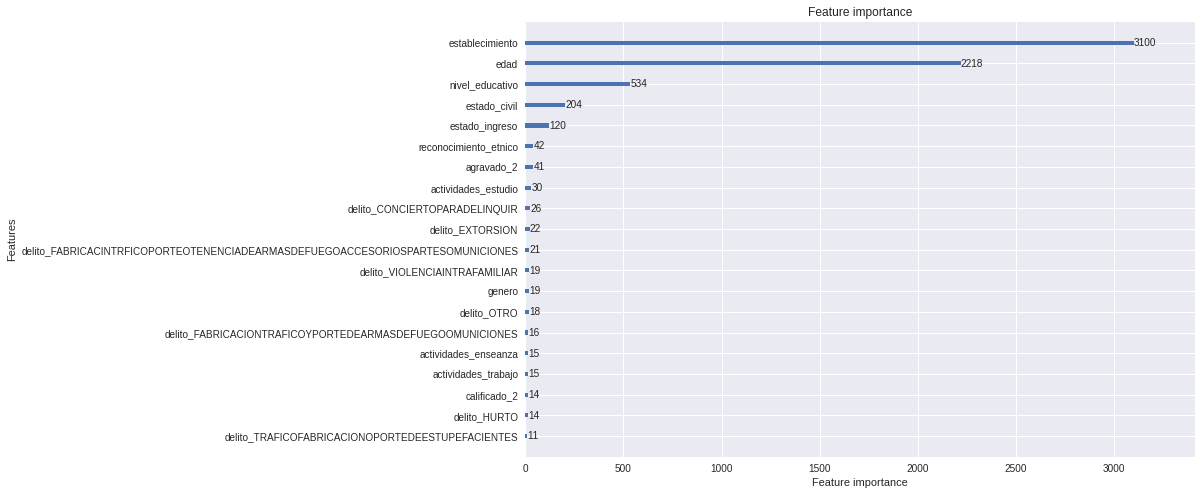

In [159]:
ax = lgb.plot_importance(model, figsize=(12,8), max_num_features = 20)

In [160]:
importance_values = model.booster_.feature_importance(importance_type='split')
feature_name = model.booster_.feature_name()

In [161]:
feature_importance = pd.DataFrame(np.concatenate((np.array(feature_name).reshape(-1,1),
                                  importance_values.reshape(-1,1).astype(int)), 
                            axis = 1), 
                     columns = ['feature_name', 'feature_importance'])
feature_importance['feature_importance'] = feature_importance['feature_importance'].astype(int)
feature_importance = feature_importance.sort_values(by=['feature_importance'], ascending = False)[:20]
feature_importance

,feature_name,feature_importance
8,establecimiento,3100
9,edad,2218
3,nivel_educativo,534
2,estado_civil,204
7,estado_ingreso,120
4,reconocimiento_etnico,42
30,agravado_2,41
10,actividades_estudio,30
18,delito_CONCIERTOPARADELINQUIR,26
19,delito_EXTORSION,22


#### LightGBM Classifier one vs all

In [162]:
grouped_FI = pd.DataFrame()
for label in np.unique(Y_train):
    print('Label: {}'.format(label))
    Y_train_ova = (Y_train == label).astype(int)
    Y_test_ova = (Y_test == label).astype(int)
    ##### Hyperparameter Search
    model = lgb.LGBMClassifier(objective = "binary",
                               metric = ["binary_error","auc", "cross_entropy"],
                               scale_pos_weight = sum(Y_train_ova == 0)/sum(Y_train_ova == 1), 
                               #is_unbalance = True,
                              )

    distributions_lgb = dict(
                         #lambda_l1=uniform(loc=0, scale=50),
                         lambda_l2=uniform(loc=0, scale=1),
                         min_gain_to_split=uniform(loc=0, scale=50),
                         max_depth = randint(1, 2000),
                         n_estimators = randint(1, 2000),
                         num_iterations = randint(1, 200),
                         num_leaves = randint(1, 20000),
                         learning_rate = uniform(loc=0, scale=0.2),
                         bagging_fraction = uniform(loc=0.2, scale=0.8),
                         bagging_freq = randint(0, 5),
                         feature_fraction = uniform(loc=0.2, scale=0.8),
                         #min_data_in_leaf = randint(1, 30000)
                        )
    clf_lgb = RandomizedSearchCV(
                             model, 
                             distributions_lgb, 
                             random_state=42, 
                             cv = StratifiedKFold(n_splits=10),
                             scoring = 'f1_weighted'
                             #scoring = ['precision','recall','roc_auc'],
                             #refit = 'precision'
                            )
    search_lgb = clf_lgb.fit(X_train, Y_train_ova)
    hyper_params = search_lgb.best_params_

    ##### Model Training with tuned hyperparameters
    model = lgb.LGBMClassifier(objective = "binary",
                               metric = ["binary_error","auc", "cross_entropy"],
                               learning_rate = hyper_params['learning_rate'],
                               feature_fraction = hyper_params['feature_fraction'],
                               bagging_fraction = hyper_params['bagging_fraction'],
                               bagging_freq = hyper_params['bagging_freq'],
                               num_iterations = hyper_params['num_iterations'],
                               num_leaves = hyper_params['num_leaves'],
                               #min_data_in_leaf = hyper_params['min_data_in_leaf'],
                               max_depth = hyper_params['max_depth'],
                               n_estimators = hyper_params['n_estimators'],
                               scale_pos_weight = sum(Y_train_ova == 0)/sum(Y_train_ova == 1),
                               #is_unbalance = True,
                               importance_type = 'gain',
                               #lambda_l1 = hyper_params['lambda_l1'],
                               lambda_l2 = hyper_params['lambda_l2'],
                               min_gain_to_split = hyper_params['min_gain_to_split']
                              )
    model.fit(
              X_train, Y_train_ova, 
              eval_set=[
                        (X_test, Y_test_ova), 
                        (X_train, Y_train_ova)],
              feature_name = list(data_encoded.columns),
              verbose = 0
             )

    # Calculating Feature Importances
    importance_values = model.booster_.feature_importance(importance_type='split')
    feature_name = model.booster_.feature_name()
    feature_importance = pd.DataFrame(np.concatenate((np.array(feature_name).reshape(-1,1),
                                      importance_values.reshape(-1,1).astype(int)), 
                                axis = 1), 
                         columns = ['feature_name', 'feature_importance'])
    feature_importance['feature_importance'] = feature_importance['feature_importance'].astype(int)
    feature_importance = feature_importance.sort_values(by=['feature_importance'], ascending = False)
    feature_importance['label'] = label
    grouped_FI = pd.concat([grouped_FI, feature_importance], axis = 0)

Label: 0


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

Label: 1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

Label: 2


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

Label: 3


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

Label: 4


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

In [163]:
grouped_FI.to_csv('data/cluster_grouped_FI_no_HDI_one_hot.csv', index = False)

#### Radar Chart

In [164]:
id_feature_name = grouped_FI[['feature_name']].reset_index()

In [165]:
nlargest = grouped_FI.groupby(['label'])['feature_importance'].nlargest(30).reset_index()

In [166]:
joined = id_feature_name.merge(nlargest, left_on = 'index', right_on='level_1', how = 'inner')
joined = joined.drop(columns = ['index'])
joined = joined.drop_duplicates()
joined = joined[~joined['feature_name'].str.contains('JAIL')]
joined = grouped_FI[grouped_FI['feature_name'].isin(joined['feature_name'].unique())]

In [171]:
radar_plot(joined)

In [45]:
belong_to_all = joined[joined.groupby('feature_name')['label'].transform('nunique') == joined['label'].nunique()]['feature_name'].unique()

In [46]:
belong_to_all = pd.DataFrame(belong_to_all, columns = ['feature_names'])
#belong_to_all = belong_to_all[~belong_to_all['feature_names'].str.contains('JAIL')]

In [47]:
data_plot = grouped_FI[grouped_FI['feature_name'].isin(belong_to_all['feature_names'].tolist() +
                                                       ['SEVERITY','timejail_day','recidivism_day','edad'])]
data_plot

,feature_name,feature_importance,label
222,recidivism_day,24,0
221,timejail_day,24,0
10,SEVERITY,10,0
221,timejail_day,11,1
222,recidivism_day,0,1
10,SEVERITY,0,1
221,timejail_day,167,2
10,SEVERITY,44,2
222,recidivism_day,4,2
10,SEVERITY,31,3
